Задача: выделить из датасета depositphotos картинки с изображением текста и его текстовым описанием. Нужно пройтись по описаниям (csv файлам), найти те, в которых есть слова text, word, written, writing, letter, inscription (стоит добавить сюда ещё слов, связанных с описанием изображённого текста). Отобранные картинки и описания нужно сохранить в директорию datasets_v3/text_image/depositphotos_text/ в формате:
datasets_v3/text_image/depositphotos_text/shards/i.csv
datasets_v3/text_image/depositphotos_text/shards/i.csv
где в каждом csv файле содержится 1000 описаний, а в каждом тарнике 1000 соответствующих изображений. Формат csv файла такой же, как и в datasets_v3/text_image/depositphotos/depositphotos_j/shards/k.csv. После этого в csv файлы отобранного текстового сета нужно будет добавить доп колонку с информацией о проценте пространства, занимаеиого текстом на картинке.

!!!ВНИМАНИЕ!!! никакие файлы из исходного датасета datasets_v3/text_image/depositphotos не перезаписываются. Их можно только читать.

In [1]:
import io
import re
import tarfile
import boto3

from tqdm import tqdm
import numpy as np
import pandas as pd
from PIL import Image
import math 
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import glob
import shutil

## Upload s3

In [2]:
BUCKET_NAME = '...'
s3 = boto3.client(
    "s3",
    aws_access_key_id='...',
    aws_secret_access_key='...',
    endpoint_url='...'
)

In [12]:
def get_all_paths(prefix):
    paginator = s3.get_paginator('list_objects_v2')
    pages = paginator.paginate(
        Bucket=BUCKET_NAME,
        Prefix=prefix
    )
    all_paths = []
    for page in pages:
        for obj in page['Contents']:
            if obj['Key'].split('.')[-1] == 'csv':
                all_paths.append(obj['Key'])
    return all_paths

### Create directory for saved images from one shard

In [105]:
def save_image_shard(all_data, save_dir):
    
    for idx in tqdm(range(len(all_data))):

        data = all_data.iloc[[idx]]
        caption = data.caption.item()
        key = data.key.item()
        download_buffer = io.BytesIO()
        s3.download_fileobj(BUCKET_NAME, text_file[:-3] + 'tar', download_buffer)
        download_buffer.seek(0)
        with tarfile.open(fileobj=download_buffer) as tar:
            member = tar.getmember(data.image_name.item())
            image = tar.extractfile(member)
            image = Image.open(io.BytesIO(image.read()))
            save_dir = directory_shard
            name = all_data.iloc[[idx]].image_name.item()
            image.save(save_dir + '/' + name)

## Open image whose capture contain key word

In [10]:
def get_caption(all_data, key):
    image_arr = []
    for i in range(len(all_data)):
        if key in all_data.iloc[[i]].caption.item():
            image_arr.append(i)
    return image_arr       


In [11]:
def get_image(all_data,idx):
    
    data = all_data.iloc[[idx]]
    caption = data.caption.item()
    download_buffer = io.BytesIO()
    s3.download_fileobj(BUCKET_NAME, text_file[:-3] + 'tar', download_buffer)
    download_buffer.seek(0)
    with tarfile.open(fileobj=download_buffer) as tar:
        member = tar.getmember(data.image_name.item())
    #     image = tar.extractfile(member)
    #     image = Image.open(io.BytesIO(image.read()))
    # print(image.size)
    return member, caption

In [13]:
def get_idx(all_data,key_list):

    final_idx = [] #out: line number
    for key in key_list:
        image_arr = get_caption(all_data, key)
        final_idx.extend(image_arr)
    return final_idx

### CRAFT model

In [ ]:
!git clone https://github.com/clovaai/CRAFT-pytorch

In [ ]:
!pip install torch
!pip install torchvision
!pip install opencv-python
!pip install scikit-image
!pip install scipy

In [9]:
!pip install torchvision==0.9.0

  Attempting uninstall: torch
    Found existing installation: torch 2.0.1
    Uninstalling torch-2.0.1:
      Successfully uninstalled torch-2.0.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.2.1
    Uninstalling torchvision-0.2.1:
      Successfully uninstalled torchvision-0.2.1


In [5]:
project_name = 'C:/Users/annai/Sber_Practic/CRAFT-pytorch'
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"  
import sys
sys.path.append(project_name)

weightfile = 'C:/Users/annai/Sber_Practic/craft_mlt_25k.pth'

Loading weights from checkpoint (C:/Users/annai/Sber_Practic/craft_mlt_25k.pth)


Traceback (most recent call last):
  File "C:\Users\annai\Sber_Practic\CRAFT-pytorch\test.py", line 128, in <module>
    net.load_state_dict(copyStateDict(torch.load(args.trained_model)))
  File "C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py", line 593, in load
    return _legacy_load(opened_file, map_location, pickle_module, **pickle_load_args)
  File "C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py", line 772, in _legacy_load
    result = unpickler.load()
  File "C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py", line 728, in persistent_load
    deserialized_objects[root_key] = restore_location(obj, location)
  File "C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py", line 175, in default_restore_location
    result = fn(storage, location)
  File "C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py", line 151, in _cuda_deserialize
    device = validate_cuda_device(location)
  File "C:\ProgramData\Ana

### Get area percent for selected image and delite all files in CRAFT result directory

In [ ]:
def percent_area(result_path):
    
    all_files = [f for f in listdir(result_path) if isfile(join(result_path, f))]
    new_data = {} #image_name as key and the percentage occupied by the text as a value
    
    for name in all_files:
        if 'txt' in name:
            
            idx = int(name.split('.')[0].split('res_')[1])

            name_txt = 'res_'+ str(idx) + '.txt'
            name_mask = 'res_'+ str(idx) + '_mask.jpg'
            name_jpg = 'res_'+ str(idx) + '.jpg'
            path_txt = mypath + '/' + name_txt
            path_jpg = mypath + '/' + name_jpg
            path_mask = mypath + '/' + name_mask

            name = str(idx) + '.jpg'

            #get original size of image
            w = df.loc[df['image_name'] == name].width.item()
            h = df.loc[df['image_name'] == name].height.item()
            s = w*h

            # if the image does not contain text, txt file size = 0
            if os.stat(path_txt).st_size == 0:
                new_data[name] = 0
                
        else:
        # Otherwise, open the file and look at the size of the frame 
            f = open(path_txt,'r')
            lines = f.readlines()
            square_sum = []
            for line in lines:
                l = line.strip()
                x1,y1,x2,y2,x3,y3,x4,y4 = l.split(',')
                x1 = int(x1)
                y1 = int(y1)
                x2 = int(x2)
                y2 = int(y2)
                x3 = int(x3)
                y3 = int(y3)
                x4 = int(x4)
                y4 = int(y4)
                wi = math.sqrt((x2-x1)**2 +(y2-y1)**2 )
                hi = math.sqrt((x4-x1)**2 +(y4-y1)**2 ) 
                si = wi*hi #for ONE bbox
                square_sum.append(si)
                #if  image contains at least one large frame, leave this image

            f.close

            sum = math.fsum(square_sum) #sum all bboxes
            pers = np.round(sum/s*100,2)
            new_data[name] = pers

            #delete image, mask and txt.It is unimportant waste
            os.remove(path_txt)
            os.remove(path_jpg)
            os.remove(path_mask)
    
    return new_data



In [54]:
# new_data = {'29544026.jpg': 12.04,
#  '29544121.jpg': 46.99,
#  '29544440.jpg': 12.56,
#  '29544042.jpg': 26.13,
#  '29544271.jpg': 8.39,
#  '29544136.jpg': 5.1,
#  '29544479.jpg': 8.27,
#  '29544191.jpg': 6.58,
#  '29544125.jpg': 13.42,
#  '29544120.jpg': 21.02,
#  '29544112.jpg': 59.54,
#  '29544183.jpg': 10.69,
#  '29544089.jpg': 20.35,
#  '29544166.jpg': 24.55,
#  '29544122.jpg': 9.96,
#  '29544176.jpg': 12.82}

### Save the sorted and resized images in a folder

In [28]:
def resize_img(image, img_path):

    width, height = image.size
    if width < height:
        ratio = height/width
        new_w = 1024
        new_h = ratio*new_w
    else:
        ratio = width/height
        new_h = 1024
        new_w = ratio*new_h
        
    image_resized = image.resize((int(new_w), int(new_h)))
    image_resized.save(img_path)

### Update csv data

#### Create new dataframe with new last column

In [59]:
def update_data(all_data, new_data):
    
    #get names of all_data columns
    name_columns = list(all_data.columns.values)
    #add one column in the end
    name_columns.append('% text area')
    
    #create new DataFrame for new shard
    data_text_img = pd.DataFrame(columns=name_columns)
    
    #add data to the new table
    for k, v in new_data.items():
        data_i = all_data.loc[all_data['image_name'] == k]
        data_i.insert(loc= len(data_i.columns), column='% text area', value=v)
        data_text_img = pd.concat([data_text_img,data_i], ignore_index=True)
        
    return data_text_img

In [70]:
# data_text_img.head()

,key,image_name,caption,url,metadata,width,height,channels,is_correct,watermark_resnext50_32x4d-small,...,"ViT-L/14 clip score ""picture has watermark""","ViT-L/14 clip score ""slide of presentation with text""","ViT-L/14 clip score ""document with text""","ViT-L/14 clip score ""web site with text""",watermark_prob,webdocument_prob,image_phash_8,is_duplicate,clip_ViT-L/14_similarity,% text area
0,65770265,29544026.jpg,"Stagnation or Growth Green Road Sign, business...",https://st2.depositphotos.com/4428871/6577/i/6...,"{""alt"": ""Stagnation or Growth Green Road Sign,...",600.0,400.0,3.0,True,0,...,0.13855,0.167236,0.148682,0.147583,0.0,0.272363,eb8fffe3c60cfc7000fc7008000fe7fc000703ffd003ffc7,False,0.343506,NaN
1,65770265,29544026.jpg,"Stagnation or Growth Green Road Sign, business...",https://st2.depositphotos.com/4428871/6577/i/6...,"{""alt"": ""Stagnation or Growth Green Road Sign,...",600.0,400.0,3.0,True,0,...,0.13855,0.167236,0.148682,0.147583,0.0,0.272363,eb8fffe3c60cfc7000fc7008000fe7fc000703ffd003ffc7,False,0.343506,12.04
2,69287811,29544121.jpg,Success word cloud — Stock Image,https://st2.depositphotos.com/1047356/6928/i/6...,"{""alt"": ""Success word cloud Royalty Free Stock...",600.0,450.0,3.0,True,1,...,0.144531,0.19165,0.165161,0.198853,0.722656,0.588525,fc01ff1f803f1f8e3fe3f1c003ffc0000fc003f007e07ff8,False,0.240112,46.99
3,256967390,29544440.jpg,Colors of Netherlands — Stock Image,https://st4.depositphotos.com/13846464/25696/i...,"{""alt"": ""Colors of Netherlands Royalty Free St...",600.0,400.0,3.0,True,0,...,0.100037,0.116577,0.123535,0.138184,0.0,0.0,e40c36fc09c703fff8643e20f00fc7e38e30fc01c7e40df6,False,0.067139,12.56
4,398855394,29544042.jpg,Abstract black and white grunge background. Mo...,https://st4.depositphotos.com/34793116/39885/i...,"{""alt"": ""Abstract Black White Grunge Backgroun...",400.0,600.0,3.0,True,0,...,0.176514,0.161987,0.186157,0.193726,0.182568,0.537256,e000001f8fc0e3ffc00001f81ffe00e3ffffe381f81c71ff,False,0.194092,26.13


### Upload one file to s3

Отобранные картинки и описания нужно сохранить в директорию datasets_v3/text_image/depositphotos_text/ в формате:
datasets_v3/text_image/depositphotos_text/shards_/i.csv

In [ ]:
BUCKET_NAME = '...'
s3 = boto3.client(
    "s3",
    aws_access_key_id='...',
    aws_secret_access_key='...',
    endpoint_url='...'
)

In [16]:
#upload csv

img_path = 'C:/Users/annai/Practic/29544/29544001.jpg'

with open(img_path,'rb') as f:
    s3.upload_fileobj(f, BUCKET_NAME, '.../shards/anna_test.jpg')

In [17]:
response = s3.list_objects_v2(Bucket = BUCKET_NAME)

In [ ]:
for obj in response['Contents']:
    if 'anna_test.jpg' in obj['Key']: 
        print(obj)

In [19]:
#command for delite
file_name = '/encoding_datasets/encoded_datasets_v3/text_image/depositphotos_text/shards/anna_test.jpg'
response = s3.delete_object(Bucket=BUCKET_NAME, Key= file_name)

# Main

In [4]:
# path for csv files
paths = get_all_paths('datasets_v3/text_image/depositphotos/')

In [ ]:
result_path = 'C:/Users/annai/Sber_Practic/CRAFT-pytorch/result'

In [12]:
key_list = ['advertising', 'alphabet', 'banner', 'button', 'calendar', 'card', 'counter', 'drawing', 'greeting', 'icon', 'inscription', 'keyboard', 'label'] 
key_list.extend(['letters','logo','message','note','number','numbers','price','quote','search','showing','sign','stamp','text','welcome','word','writing','question'])  

In [ ]:
for text_file in paths:
    
    shard_name = text_file.split('shards/')[1]
    download_buffer = io.BytesIO()
    s3.download_fileobj(BUCKET_NAME, text_file, download_buffer)
    download_buffer.seek(0)
    all_data = pd.read_csv(download_buffer)
    all_data.to_csv (shard_name, index= False)
    
    # Create directory for saved images from one shard    
    directory_shard = 'C:/Users/annai/Sber_Practic/' + shard_name.split('.')[0]
    if not os.path.exists(directory_shard):
        os.makedirs(directory_shard)
    save_image_shard(all_data, directory_shard)
    
    # get index of image whose capture contain key word
    final_idx = get_idx(all_data,key_list)
    #get image names of this index
    name_list = []
    for idx in final_idx:
        name = all_data.iloc[[idx]].image_name.item()
        name_list.append(name)
        
    # remove files from the original directory(directory_shard) that do not contain the required keywords
    all_image = [f for f in listdir(directory_shard) if isfile(join(directory_shard, f))]
    for name in all_image:
        img_path = directory_shard + '/' + name
        if name in name_list:
            image = Image.open(img_path, 'r')
            resize_img(image,img_path)
        else:
            os.remove(img_path)
            
    #run the model
    !cd {project_name} && python test.py --trained_model={weightfile} --test_folder=directory_shard
    
    # Get area percent for selected image and delite all files in CRAFT result directory
    #new_data - dictionary, where image_name as key and the percentage occupied by the text as a value
    new_data = percent_area(result_path)
    data_text_img = update_data(all_data, new_data)
    
    #save new csv data in local folder
    directory_csv = 'C:/Users/annai/Sber_Practic/new_csv'
    if not os.path.exists(directory_csv):
        os.makedirs(directory_csv)
    csv_path = directory_csv + shard_name + '.csv'
    data_text_img.to_csv (csv_path, index= False )
    
    #upload to s3
    #delite all files on local store
    shutil.rmtree(directory_shard)
    

### Visualizing result

In [20]:
image_name = []

for count in tqdm(range(len(final_idx))):
    idx = final_idx[count]
    name, caption = get_image(all_data, idx)
    print('{}: {}'.format(count,caption))
    image_name.append(name)

  1%|          | 1/100 [00:14<23:18, 14.13s/it]

0: The forbidding banner "It is forbidden to jump on railway tracks — Stock Image


  2%|▏         | 2/100 [00:24<19:26, 11.91s/it]

1: Young beautiful caucasian woman holding cardboard banner with blank space with open hand doing stop sign with serious and confident expression, defense gesture — Stock Image


  3%|▎         | 3/100 [00:34<18:01, 11.15s/it]

2: Summer Atrani beach with blue umbrellas and sea water, Italy, web banner format — Stock Image


  4%|▍         | 4/100 [00:44<17:03, 10.66s/it]

3: Tech support icon elegant black round button — Stock Image


  5%|▌         | 5/100 [00:55<16:44, 10.57s/it]

4: Customer service (team icon) purple round button — Stock Image


  6%|▌         | 6/100 [01:07<17:19, 11.05s/it]

5: Avatar icon sign. Set of eight multi colored round buttons, stickers. illustration — Stock Image


  7%|▋         | 7/100 [01:18<17:35, 11.34s/it]

6: An illustration of a purple button — Stock Image


  8%|▊         | 8/100 [01:31<18:02, 11.76s/it]

7: Young happy parents showing blank Christmas card — Stock Image


  9%|▉         | 9/100 [01:46<19:14, 12.69s/it]

8: Female hands holding Merry Christmas greeting card. Flat lay of golden presents and wrapping paper rolls on background — Stock Image


 10%|█         | 10/100 [01:58<18:50, 12.57s/it]

9: Exercise bike cardio workout at fitness gym of people taking weight loss with machine aerobic for slim body — Stock Image


 11%|█         | 11/100 [02:10<18:18, 12.34s/it]

10: Young beautiful caucasian woman holding cardboard banner with blank space with open hand doing stop sign with serious and confident expression, defense gesture — Stock Image


 12%|█▏        | 12/100 [02:19<16:44, 11.42s/it]

11: Man holding credit card and working on laptop on home interior background — Stock Image


 13%|█▎        | 13/100 [02:29<15:39, 10.80s/it]

12: Exchanging business card with business partner — Stock Image


 14%|█▍        | 14/100 [02:40<15:52, 11.07s/it]

13: Overhead view of a charming little Caucasian girl in pajamas with colorful dots sitting inside a cardboard box and looking at camera, isolated over beige background with copy ad space — Stock Image


 15%|█▌        | 15/100 [02:53<16:33, 11.69s/it]

14: Multi exposure of brain drawing and office interior background. Concept of data technology. — Stock Image


 16%|█▌        | 16/100 [03:04<15:43, 11.23s/it]

15: Architect working on drawing table in office — Stock Image


 17%|█▋        | 17/100 [03:13<14:54, 10.77s/it]

16: Double exposure of social network theme drawing hologram over coffee cup background in office. Concept people connection. — Stock Image


 18%|█▊        | 18/100 [03:24<14:28, 10.60s/it]

17: Female hands holding Merry Christmas greeting card. Flat lay of golden presents and wrapping paper rolls on background — Stock Image


 19%|█▉        | 19/100 [03:34<14:10, 10.51s/it]

18: Group of business colleagues working on technology at business process to achieve tremendous growth in commerce. Worldwide process to conduct transactions. Tech hologram icons over Kuala Lumpur — Stock Image


 20%|██        | 20/100 [03:44<13:53, 10.41s/it]

19: Tech support icon elegant black round button — Stock Image


 21%|██        | 21/100 [03:54<13:29, 10.24s/it]

20: Customer service (team icon) purple round button — Stock Image


 22%|██▏       | 22/100 [04:04<13:13, 10.18s/it]

21: People holding icons related to money and currency concept — Stock Image


 23%|██▎       | 23/100 [04:15<13:15, 10.33s/it]

22: Hand holding icon of dental care — Stock Image


 24%|██▍       | 24/100 [04:24<12:49, 10.12s/it]

23: Avatar icon sign. Set of eight multi colored round buttons, stickers. illustration — Stock Image


 25%|██▌       | 25/100 [04:34<12:22,  9.90s/it]

24: Tourists at the entrance of Hagia Sophia. This VI century iconic cathedral is in news because of the decision of Turkey to convert it back into a mosque. — Stock Image


 26%|██▌       | 26/100 [04:45<12:54, 10.47s/it]

25: Businessman in suit holding out hand icon of user. Internet icons interface foreground. global network media concept,contact on virtual screens ,copy space. — Stock Image


 27%|██▋       | 27/100 [04:57<13:00, 10.70s/it]

26: Engineer working on a social media concept with WORLDWIDE inscription — Stock Image


 28%|██▊       | 28/100 [05:09<13:23, 11.15s/it]

27: Man typing on a laptop keyboard on a wooden table and tree. Business concept — Stock Image


 29%|██▉       | 29/100 [05:24<14:41, 12.41s/it]

28: Beautiful happy redhead girl, pointing fingers left and looking at logo pleased, standing in sweater against blue background — Stock Image


 30%|███       | 30/100 [05:41<15:56, 13.66s/it]

29: Sticky note pinned on pinboard — Stock Image


 31%|███       | 31/100 [05:50<14:15, 12.40s/it]

30: Smiling asian woman writing in a notebook and laptop. Summer in the park. High quality photo — Stock Image


 32%|███▏      | 32/100 [06:01<13:21, 11.79s/it]

31: Family psychologist taking information about patients family, counselor making notes during therapy session — Stock Image


 33%|███▎      | 33/100 [06:10<12:23, 11.10s/it]

32: Smart working. Young woman in front of pc notebook. Information technology. Attention gesture — Stock Image


 34%|███▍      | 34/100 [06:19<11:35, 10.54s/it]

33: Beautiful hispanic woman holding 50 israel shekels banknotes smiling happy pointing with hand and finger to the side — Stock Image


 35%|███▌      | 35/100 [06:29<10:58, 10.13s/it]

34: A young girl with a notebook and a pen in her hand is solving her homework. writes notes to notepad — Stock Image


 36%|███▌      | 36/100 [06:38<10:36,  9.95s/it]

35: Skilled young woodworker standing at a workbench in his carpentry shop using a digital tablet and holding a notebook of designs — Stock Image


 37%|███▋      | 37/100 [06:47<10:11,  9.70s/it]

36: Middle age hoary senior man over isolated background showing and pointing up with fingers number eight while smiling confident and happy. — Stock Image


 38%|███▊      | 38/100 [06:57<10:10,  9.85s/it]

37: Woman with champagne celebrating new year 2019 counting number one sign — Stock Image


 39%|███▉      | 39/100 [07:08<10:20, 10.18s/it]

38: Young man smiling and looking friendly, showing number five or fifth with hand forward, counting down against white background — Stock Image


 40%|████      | 40/100 [07:18<09:55,  9.93s/it]

39: Adult hispanic doctor man over isolated background showing and pointing up with fingers number six while smiling confident and happy. — Stock Image


 41%|████      | 41/100 [07:27<09:40,  9.84s/it]

40: Young handsome african american man with dreadlocks wearing striped t-shirt and wool hat showing and pointing up with fingers number five while smiling confident and happy. — Stock Image


 42%|████▏     | 42/100 [07:37<09:22,  9.70s/it]

41: Believer girl stands in the temple in the rays of light and looks up in search of God — Stock Image


 43%|████▎     | 43/100 [07:46<09:03,  9.54s/it]

42: Hands of a female researcher doing research in a lab (color tone — Stock Image


 44%|████▍     | 44/100 [07:57<09:23, 10.06s/it]

43: Business Research Concept — Stock Image


 45%|████▌     | 45/100 [08:07<09:16, 10.11s/it]

44: Businessman man hand hold interface question marks sign web. Ask quiestion online, FAQ concept, what where when how and why, search information on internet. — Stock Image


 46%|████▌     | 46/100 [08:17<08:51,  9.85s/it]

45: Young beautiful latin girl wearing architect hardhat and glasses very happy and smiling looking far away with hand over head. searching concept. — Stock Image


 47%|████▋     | 47/100 [08:26<08:34,  9.71s/it]

46: Middle age hoary senior man over isolated background showing and pointing up with fingers number eight while smiling confident and happy. — Stock Image


 48%|████▊     | 48/100 [08:36<08:27,  9.75s/it]

47: Happy african american girl smiling and showing thumbs up isolated over yellow background — Stock Image


 49%|████▉     | 49/100 [08:45<08:11,  9.64s/it]

48: Group of Kid, young girl and Middle age blonde woman with grey dress showing an ok sign with fingers. Face of happiness and satisfaction — Stock Image


 50%|█████     | 50/100 [08:55<07:57,  9.55s/it]

49: Tattooer showing process of making a tattoo on young beautiful hipster woman with red curly hair . Tattoo design in the form of rose — Stock Image


 51%|█████     | 51/100 [09:05<08:04,  9.88s/it]

50: Young man smiling and looking friendly, showing number five or fifth with hand forward, counting down against white background — Stock Image


 52%|█████▏    | 52/100 [09:15<07:46,  9.72s/it]

51: Adult hispanic doctor man over isolated background showing and pointing up with fingers number six while smiling confident and happy. — Stock Image


 53%|█████▎    | 53/100 [09:23<07:24,  9.46s/it]

52: Collage of young handsome man over isolated background gesturing with hands showing big and large size sign, measure symbol. Smiling looking at the camera. Measuring concept. — Stock Image


 54%|█████▍    | 54/100 [09:32<07:10,  9.35s/it]

53: Young happy parents showing blank Christmas card — Stock Image


 55%|█████▌    | 55/100 [09:42<07:05,  9.45s/it]

54: Colorful arrows showing to center — Stock Image


 56%|█████▌    | 56/100 [09:52<07:03,  9.63s/it]

55: Model showing thumbs down — Stock Image


 57%|█████▋    | 57/100 [10:03<07:09,  9.98s/it]

56: Business people group showing teamwork and joining hands or giving five in sunny office. Unknown businessman and women making circle with their hands — Stock Image


 58%|█████▊    | 58/100 [10:13<07:04, 10.11s/it]

57: Young man in red shirt showing framing hand gesture — Stock Image


 59%|█████▉    | 59/100 [10:23<06:48,  9.97s/it]

58: Girl sitting on pile of books showing thumbs up. — Stock Image


 60%|██████    | 60/100 [10:32<06:27,  9.69s/it]

59: Young handsome african american man with dreadlocks wearing striped t-shirt and wool hat showing and pointing up with fingers number five while smiling confident and happy. — Stock Image


 61%|██████    | 61/100 [10:44<06:46, 10.43s/it]

60: Cute woman with signs — Stock Image


 62%|██████▏   | 62/100 [10:55<06:41, 10.57s/it]

61: Group of Kid, young girl and Middle age blonde woman with grey dress showing an ok sign with fingers. Face of happiness and satisfaction — Stock Image


 63%|██████▎   | 63/100 [11:07<06:41, 10.86s/it]

62: Woman with champagne celebrating new year 2019 counting number one sign — Stock Image


 64%|██████▍   | 64/100 [11:18<06:32, 10.90s/it]

63: Tattooer showing process of making a tattoo on young beautiful hipster woman with red curly hair . Tattoo design in the form of rose — Stock Image


 65%|██████▌   | 65/100 [11:27<06:07, 10.49s/it]

64: Designer Pamella Roland — Stock Image


 66%|██████▌   | 66/100 [11:37<05:51, 10.33s/it]

65: Top view of retro flag of Gay Pride, Turkey with grunge texture, no flagpole. Plane design, layout. Flag background. Freedom and love concept. Pride month, activism, community and freedom — Stock Image


 67%|██████▋   | 67/100 [12:03<08:12, 14.93s/it]

66: Collage of young handsome man over isolated background gesturing with hands showing big and large size sign, measure symbol. Smiling looking at the camera. Measuring concept. — Stock Image


 68%|██████▊   | 68/100 [12:43<12:02, 22.58s/it]

67: Forest as a background. A view of the natural landscape in the mountains. Pine trees. Large resolution photo for the design. — Stock Image


 69%|██████▉   | 69/100 [12:53<09:43, 18.81s/it]

68: Luxury and beautiful living room interior design — Stock Image


 70%|███████   | 70/100 [13:03<08:04, 16.14s/it]

69: Fresh Summer Lady look. Vanilla flowers Girl Candy colors design trends — Stock Image


 71%|███████   | 71/100 [13:14<06:58, 14.43s/it]

70: Young Brazilian man isolated on white background holding a sign with a growing statistics arrow symbol and doing phone gesture — Stock Image


 72%|███████▏  | 72/100 [13:24<06:13, 13.35s/it]

71: Handsome toddler child with green eyes annoyed with bad attitude making stop sign with hand, saying no, expressing security, defense or restriction, maybe pushing at school corridor — Stock Image


 73%|███████▎  | 73/100 [13:36<05:43, 12.74s/it]

72: Avatar icon sign. Set of eight multi colored round buttons, stickers. illustration — Stock Image


 74%|███████▍  | 74/100 [13:45<05:07, 11.84s/it]

73: Young beautiful caucasian woman holding cardboard banner with blank space with open hand doing stop sign with serious and confident expression, defense gesture — Stock Image


 75%|███████▌  | 75/100 [13:56<04:42, 11.30s/it]

74: Snowman with wooden sign — Stock Image


 76%|███████▌  | 76/100 [14:07<04:29, 11.23s/it]

75: Skilled young woodworker standing at a workbench in his carpentry shop using a digital tablet and holding a notebook of designs — Stock Image


 77%|███████▋  | 77/100 [14:17<04:10, 10.87s/it]

76: Businessman man hand hold interface question marks sign web. Ask quiestion online, FAQ concept, what where when how and why, search information on internet. — Stock Image


 78%|███████▊  | 78/100 [14:27<03:58, 10.83s/it]

77: Senior artist man at art studio smiling and confident gesturing with hand doing small size sign with fingers looking and the camera. measure concept. — Stock Image


 79%|███████▉  | 79/100 [14:38<03:43, 10.66s/it]

78: Smiling girl gesturing OK sign with her hand — Stock Image


 80%|████████  | 80/100 [14:49<03:34, 10.72s/it]

79: Protesters wearing mask and holding signs at demonstration. Protest; Photo taken during a protest against the President of Brazil, Bolsonaro, and asking for agility in the purchase of vaccines to immunize the population. — Stock Image


 81%|████████  | 81/100 [14:59<03:23, 10.70s/it]

80: Orihuela, Spain- June 15, 2016: Beauty salon with modern design in European country — Stock Image


 82%|████████▏ | 82/100 [15:11<03:19, 11.06s/it]

81: Modern coffee shop design interior, stock photo — Stock Image


 83%|████████▎ | 83/100 [15:21<03:03, 10.80s/it]

82: Man wearing formal clothing posing with selfie stick in urban environment smiling using right hand to make a signal while tongue is out — Stock Image


 84%|████████▍ | 84/100 [15:32<02:52, 10.78s/it]

83: Husband and wife in pajamas have fun in a stylish bathroom, interior design — Stock Image


 85%|████████▌ | 85/100 [15:44<02:46, 11.07s/it]

84: Top view of retro flag of Gay Pride, Turkey with grunge texture, no flagpole. Plane design, layout. Flag background. Freedom and love concept. Pride month, activism, community and freedom — Stock Image


 86%|████████▌ | 86/100 [15:56<02:39, 11.38s/it]

85: Top view of abstract green ice textured background — Stock Image


 87%|████████▋ | 87/100 [16:11<02:41, 12.39s/it]

86: Athletic girl sitting on a white background, space for text — Stock Image


 88%|████████▊ | 88/100 [16:25<02:34, 12.89s/it]

87: A man in white gloves holds a white sheet behind his back, Kyoto, Japan. Copy space for text. Frame for text — Stock Image


 89%|████████▉ | 89/100 [16:36<02:15, 12.29s/it]

88: Coral reef macro ,texture, abstract marine ecosystem background on a coral — Stock Image


 90%|█████████ | 90/100 [16:47<02:00, 12.10s/it]

89: Businessman using mobile phone walking in city street and commut to work texting on smartphone. Urban lifestyle of the young entrepreneur — Stock Image


 91%|█████████ | 91/100 [16:58<01:44, 11.63s/it]

90: Handsome man with striped sweater keeping the arms crossed while smiling over textured wall — Stock Image


 92%|█████████▏| 92/100 [17:09<01:31, 11.49s/it]

91: A cute schoolgirl in a uniform with glasses stands on a white background with a place for text — Stock Image


 93%|█████████▎| 93/100 [17:22<01:23, 11.87s/it]

92: Abstract conceptual creative background with space for text — Stock Image


 94%|█████████▍| 94/100 [17:31<01:07, 11.22s/it]

93: Background texture Universal georgette with a silk print, drawin — Stock Image


 95%|█████████▌| 95/100 [17:43<00:56, 11.22s/it]

94: Smiling little girl with blank text bubble — Stock Image


 96%|█████████▌| 96/100 [17:53<00:43, 10.85s/it]

95: Herrin typography, wordart, wordcloud, woman, people, lady — Stock Image


 97%|█████████▋| 97/100 [18:03<00:32, 10.73s/it]

96: Connected to the word — Stock Image


 98%|█████████▊| 98/100 [18:14<00:21, 10.93s/it]

97: Job word with work tools. 3d illustration — Stock Image


 99%|█████████▉| 99/100 [18:31<00:12, 12.61s/it]

98: Oriental male doctor holding a writing board — Stock Image


100%|██████████| 100/100 [18:42<00:00, 11.22s/it]

99: Smiling asian woman writing in a notebook and laptop. Summer in the park. High quality photo — Stock Image


C:\Users\annai\AppData\Local\Temp\ipykernel_20536\3482489060.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


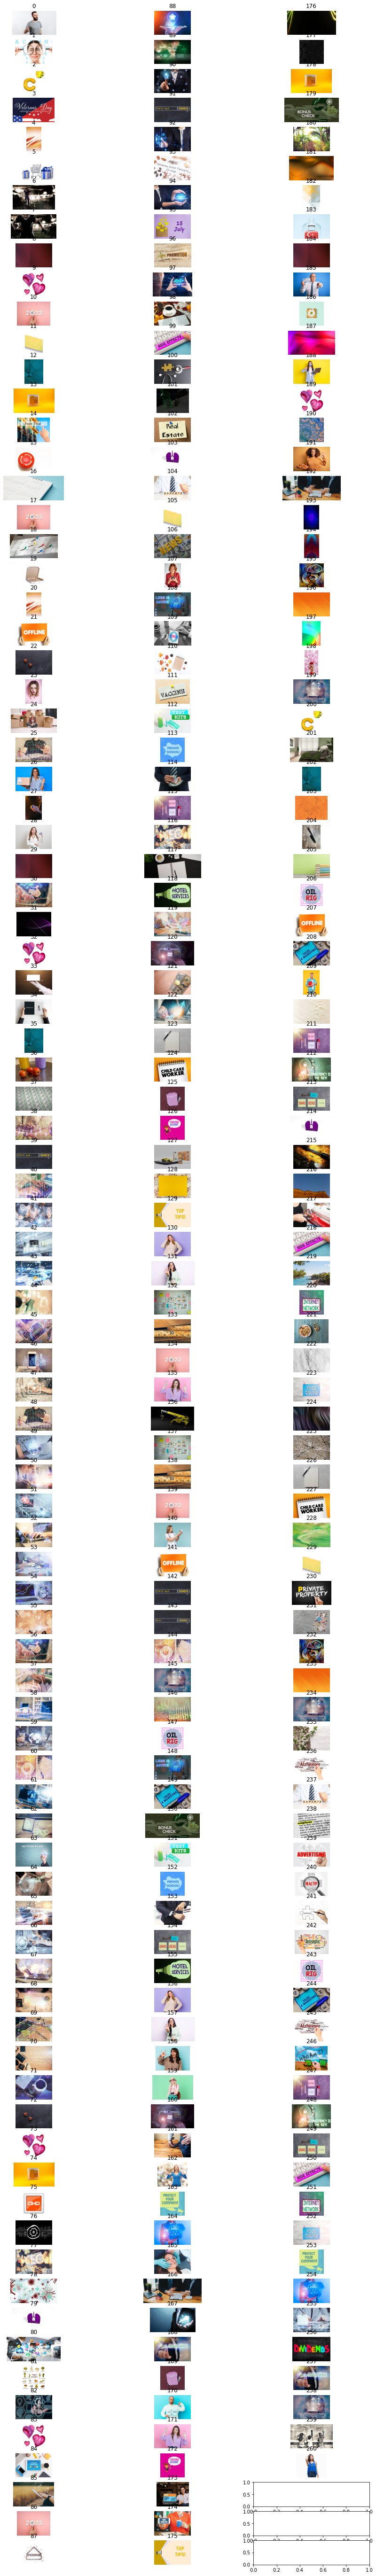

In [19]:
row = 3
line = (len(final_idx) // row) + 1
fig,ax = plt.subplots(line, row, figsize=(15, 100))    

for i,idx in enumerate(final_idx):
    member = all_data.loc[[idx]].image_name.item()
    download_buffer = io.BytesIO()
    s3.download_fileobj(BUCKET_NAME, text_file[:-3] + 'tar', download_buffer)
    download_buffer.seek(0)
    with tarfile.open(fileobj=download_buffer) as tar:
        image = tar.extractfile(member)
        image = Image.open(io.BytesIO(image.read()))
    ax[i%line][i//line].title.set_text(i)
    ax[i%line][i//line].imshow(image)
    ax[i%line][i//line].axis("off")   
fig.show()